<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202402/blob/main/Lecture10/Notebook_Boosting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Tree-Based Methods

## Boosting Trees

Let's load the packages:

In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [2]:
#packages
require("pacman")
p_load("tidyverse","ggplot2","rpart")

Loading required package: pacman



In [3]:


db<-read.csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/boosting_tree_toy.csv")
head(db)

y<-db$y
x<-db$x

,X,x,y
,<int>,<dbl>,<dbl>
1,1,0.08216883,0.19462317
2,2,0.08413394,0.07939476
3,3,0.14659427,0.06655269
4,4,0.17459164,-0.05863454
5,5,0.22330805,-0.15040834
6,6,0.29192236,0.01899571


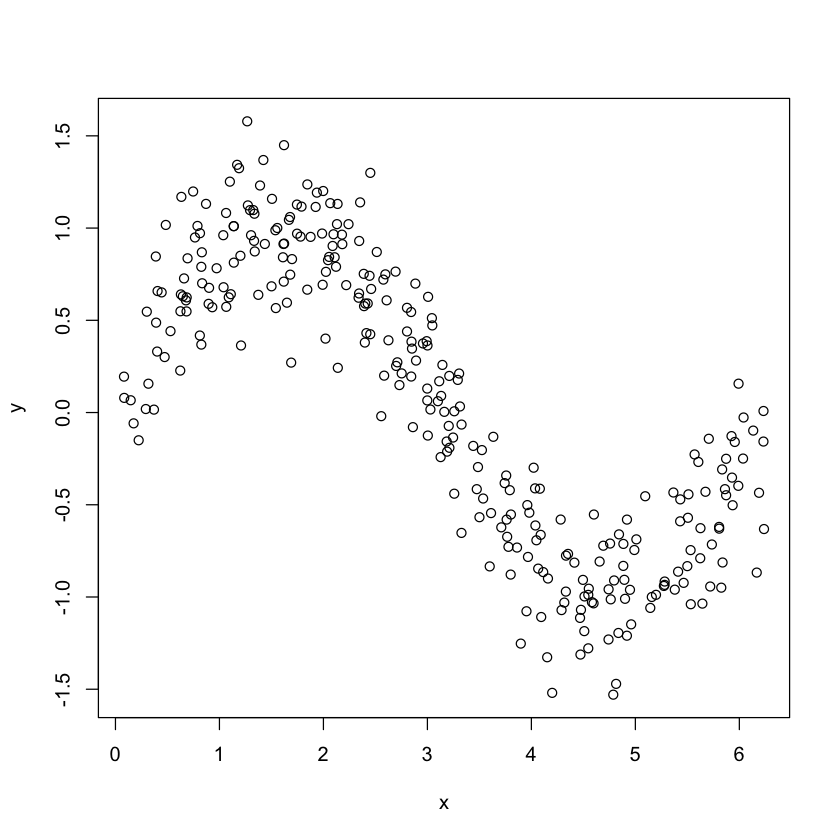

In [4]:
plot(x,y)

### Hiperparámetros

- $\lambda$ la tasa a la que aprende, los valores típicos son 0.01 o 0.001

In [5]:
lambda<-.01

- Tamaño del árbol. Arboles pocos profundos  funcionan bien.

In [6]:
d<-1 #stump

- Iniciamos fijando $\hat{f}(x)=0$ y $r_i=y_i$ para todos los $i$ del training set

In [7]:
fhat=rep(0,length(y))

r=y

In [8]:
head(y)

[1]  0.19462317  0.07939476  0.06655269 -0.05863454 -0.15040834  0.01899571

In [9]:
head(r)

[1]  0.19462317  0.07939476  0.06655269 -0.05863454 -0.15040834  0.01899571

Para $m=1,2,...,M$

 - Ajustamos un árbol $\hat{f}^m$ con $d$ bifurcaciones ($d+1$ hojas)

In [10]:
#Primera iteración
fit1<-rpart(r ~ x, control = list(maxdepth = d))
yhat1<-predict(fit1,newdata=data.frame(x))

head(lambda *yhat1)

1           2           3           4           5           6 
0.006803402 0.006803402 0.006803402 0.006803402 0.006803402 0.006803402

   - Actualizamos $\hat{f}(x)$ con una versión "shrunken" del nuevo árbol

In [11]:
f1<-fhat + lambda *yhat1

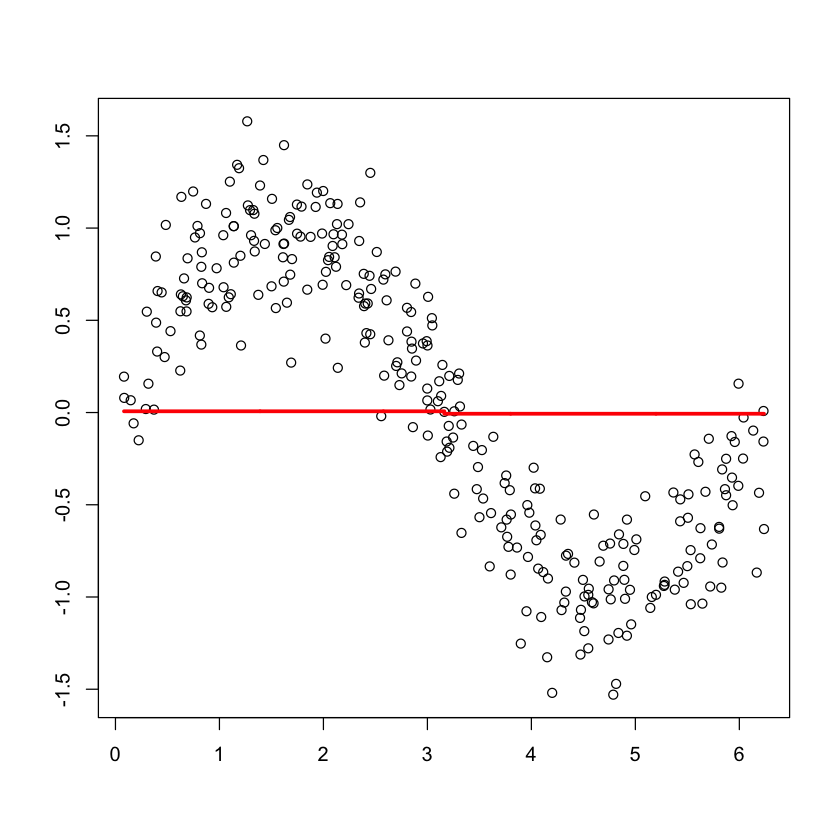

In [12]:
plot(x,y,ylab="",xlab="")
lines(x,f1,type="s",col="red",lwd=3)

- Actualizamos los residuales
  \begin{align}
  r_i\leftarrow r_i-\lambda\hat{f}^m(x)
  \end{align}

In [13]:
r1<- r - lambda*yhat1

El loop vuelve a iniciar, en la iteración 2:

In [14]:
# iteracion 2

fit2<-rpart(r1 ~ x, control = list(maxdepth = d))
yhat2<-predict(fit2,newdata=data.frame(x))
f2<- f1 + lambda *yhat2

head(lambda *yhat2)

1           2           3           4           5           6 
0.006735368 0.006735368 0.006735368 0.006735368 0.006735368 0.006735368

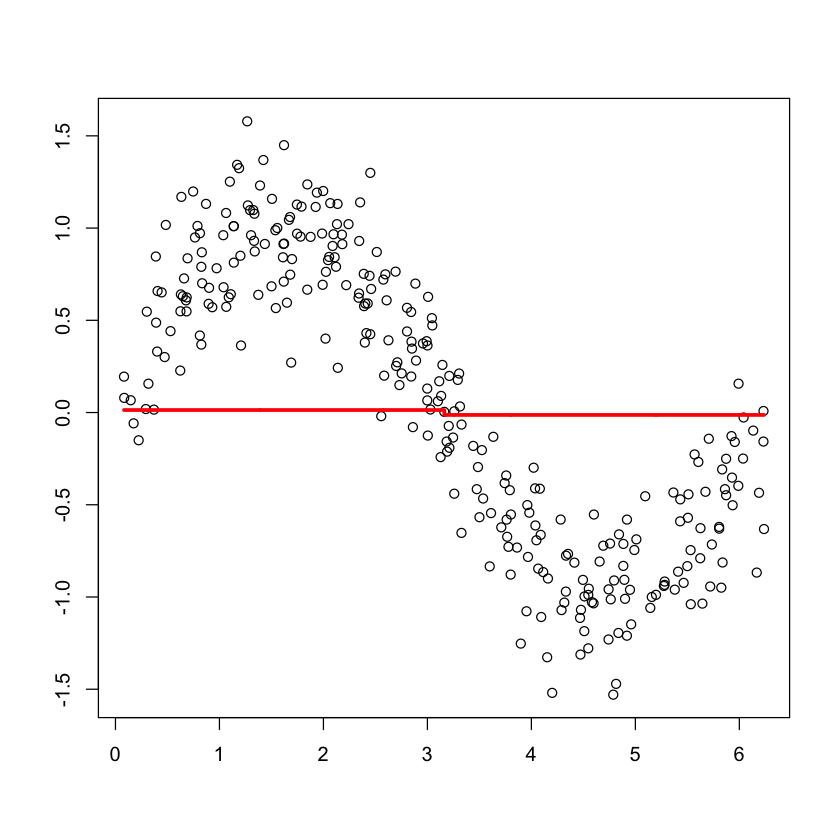

In [15]:
plot(x,y,ylab="",xlab="")
lines(x,f2,type="s",col="red",lwd=3)

In [16]:
head(f2)

1          2          3          4          5          6 
0.01353877 0.01353877 0.01353877 0.01353877 0.01353877 0.01353877

In [17]:
# En un loop
fhat<-rep(0,length(y))

r = y

YP<-lambda*fhat

for(t in 1:500){
  fit <- rpart(r~x, control = list(maxdepth = 1))
  yhat<- predict(fit,newdata=data.frame(x))
  r <-  r - lambda*yhat
  YP <-  cbind(YP,lambda*yhat)}

head(YP)

,YP,,,,,,,,,,⋯,,,,,,,,,,
1,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,⋯,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
2,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,⋯,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
3,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,⋯,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
4,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,⋯,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
5,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,⋯,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906
6,0,0.006803402,0.006735368,0.006627889,0.006724171,0.006497559,0.006591954,0.006369791,0.005899604,0.00640334,⋯,-0.0001885495,0.0003900661,-0.002124851,0.0007237985,-0.0001881118,0.0003866112,-0.003215553,-0.0001871677,0.0003850282,-0.002100906


In [18]:
sum(YP[1,c(1,2,3)])

[1] 0.01353877

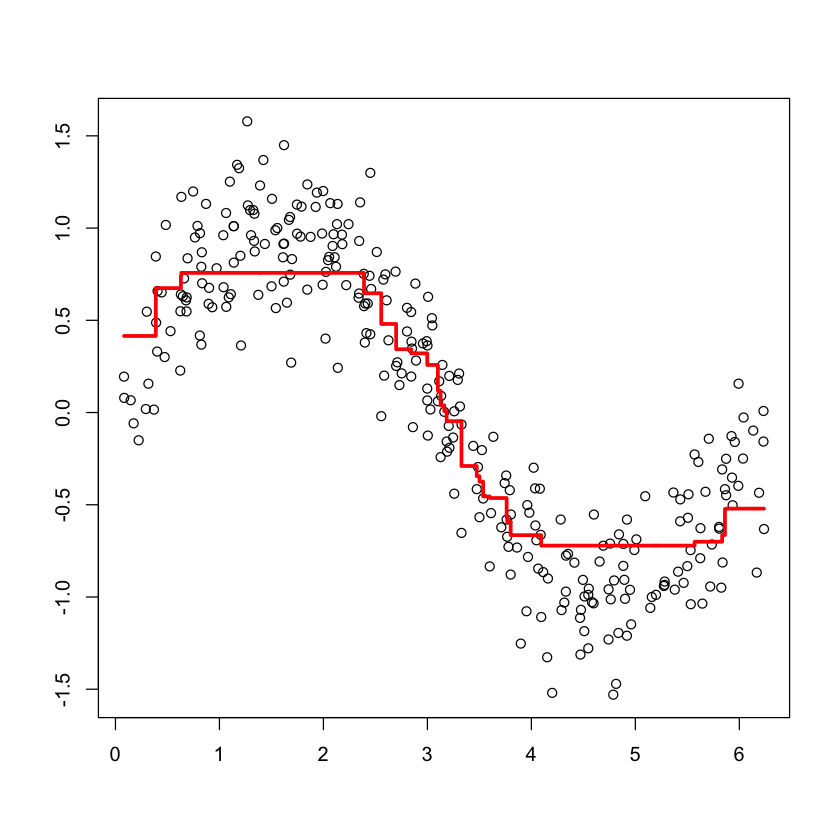

In [19]:
M<-500

fhat<-apply(YP[,1:M],1,sum)

plot(x,y,ylab="",xlab="")
lines(x,fhat,type="s",col="red",lwd=3)

## Predicting House Prices


$$
Precio=f(structural\,attributes,location,...)
$$



### Ames Data Set

The data set contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.

In [20]:
p_load("modeldata","caret")

data("ames", package = "modeldata")

In [21]:
dim(ames)

[1] 2930   74

In [22]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


The description of the variables can be viewed here: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### Gradient Boosting Trees

\begin{align}
\hat{f}_{gbm}(x)=\sum_{m=1}^{M}\lambda \hat{f}_{m}(x_{i})
\end{align}

- n.trees (# Boosting Iterations) $M$
- interaction.depth (Max Tree Depth) $J$
- shrinkage (Shrinkage) $\lambda$
- n.minobsinnode (Min. Terminal Node Size) 

In [23]:
p_load('gbm')


grid_gbm<-expand.grid(n.trees=c(200,300,500),
                      interaction.depth=c(4,6),
                      shrinkage=c(0.001,0.01),
                      n.minobsinnode = c(10,30))


grid_gbm


n.trees,interaction.depth,shrinkage,n.minobsinnode
<dbl>,<dbl>,<dbl>,<dbl>
200,4,0.001,10
300,4,0.001,10
500,4,0.001,10
200,6,0.001,10
300,6,0.001,10
500,6,0.001,10
200,4,0.010,10
300,4,0.010,10
500,4,0.010,10


In [24]:
fitControl<-trainControl(method ="cv",
                         number=5)

set.seed(1011)
gbm_tree <- train( log(Sale_Price) ~ .,
    data=ames,
  method = "gbm", 
  trControl = fitControl,
  tuneGrid=grid_gbm,
  verbose = FALSE
)            


Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 12: MS_SubClassOne_and_Half_Story_PUD_All_Ages has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 33: UtilitiesNoSeWa has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 68: NeighborhoodHayden_Lake has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 103: Overall_CondVery_Excellent has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 113: Roof_MatlMetal has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“variable 218: FunctionalSev has no variation.”
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
“v

In [25]:
gbm_tree

Stochastic Gradient Boosting 

2930 samples
  73 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2343, 2343, 2345, 2345, 2344 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  RMSE       Rsquared 
  0.001      4                  10              200      0.3635791  0.7115284
  0.001      4                  10              300      0.3450432  0.7309623
  0.001      4                  10              500      0.3129254  0.7588596
  0.001      4                  30              200      0.3635829  0.7112449
  0.001      4                  30              300      0.3449792  0.7309874
  0.001      4                  30              500      0.3128790  0.7588904
  0.001      6                  10              200      0.3597202  0.7494976
  0.001      6                  10              300      0.3394178  0.7639911
  0.001      6                  10              500      0.3045332  0.7842909
  0

In [26]:
min(gbm_tree$results$RMSE)

[1] 0.1405691

### Xgboost


\begin{align}
\mathcal{L} &= \sum_{i=1}^N L(y_i,\hat{y}_i) + \sum_{k=1}^m \Omega(f_k)
\end{align}


In [27]:
p_load('xgboost')

Hiper parametros en `R`

-  nrounds (# of trees): This parameter is similar to the random forest parameter. It determines the number of trees in the gradient-boosting forest (M). A range I often explore  100 and 1000 trees.

- max_depth (Max Tree Depth): The depth of a tree corresponds to how many branches deep each tree is allowed to go (J). A larger depth corresponds to more flexible trees, which can also lead to overfitting. The default tree depth in xgboost is 6, and it is often useful to explore max_depth range of between 4 and 8.

- eta (Shrinkage): The eta parameter controls how the boosted tree at a given iteration is merged with the tree in the previous iteration ($\eta$ in the algorithm). The default value is 0.3, and evaluating a range of effects between 0.01 and 0.5 is often important.

- min_child_weight (min obs per node) This parameter refers to the minimum allowable number of observations in each node. The default value is 1. However, this number is quite low, and caution is warranted here, particularly when the max_depth is large. I always set this value to at least ten and often explore ranges between 10 and 50.

- gamma (Minimum Loss Reduction) The gamma parameter controls the extent to which changes in the tree structure occur based on changes in the loss function (this is the $\gamma$ in the equation). The default gamma value is 0.  I often explore 0 and 1

- lambda (regularization term on weights) is the $\lambda$ parameter in the above equation. The default is set to 1.

- colsample_bytree (Subsample Ratio of Columns)
 
- subsample (Subsample Percentage)



In [28]:
grid_xbgoost <- expand.grid(nrounds = c(100,250),
                            max_depth = c(2,4), 
                            eta = c(0.01,0.05), 
                            gamma = c(0,1), 
                            min_child_weight = c(10, 25),
                            colsample_bytree = c(0.33,0.66),
                            subsample = c(0.4,0.8))

grid_xbgoost

nrounds,max_depth,eta,gamma,min_child_weight,colsample_bytree,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,2,0.01,0,10,0.33,0.4
250,2,0.01,0,10,0.33,0.4
100,4,0.01,0,10,0.33,0.4
250,4,0.01,0,10,0.33,0.4
100,2,0.05,0,10,0.33,0.4
250,2,0.05,0,10,0.33,0.4
100,4,0.05,0,10,0.33,0.4
250,4,0.05,0,10,0.33,0.4
100,2,0.01,1,10,0.33,0.4


In [29]:
set.seed(1011)
Xgboost_tree <- train(log(Sale_Price) ~ .,
    data=ames,
  method = "xgbTree", 
  trControl = fitControl,
  tuneGrid=grid_xbgoost
)        

Xgboost_tree

[19:21:39] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:40] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:41] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:42] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:43] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:45] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:46] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:48] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:48] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:21:49] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is dep

eXtreme Gradient Boosting 

2930 samples
  73 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2343, 2343, 2345, 2345, 2344 
Resampling results across tuning parameters:

  eta   max_depth  gamma  colsample_bytree  min_child_weight  subsample
  0.01  2          0      0.33              10                0.4      
  0.01  2          0      0.33              10                0.4      
  0.01  2          0      0.33              10                0.8      
  0.01  2          0      0.33              10                0.8      
  0.01  2          0      0.33              25                0.4      
  0.01  2          0      0.33              25                0.4      
  0.01  2          0      0.33              25                0.8      
  0.01  2          0      0.33              25                0.8      
  0.01  2          0      0.66              10                0.4      
  0.01  2          0      0.66              10                0.4 

In [30]:
Xgboost_tree$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,250,4,0.05,0,0.66,10,0.4


In [31]:
min(Xgboost_tree$results$RMSE)

[1] 0.1276845

It’s important to note that there is never a single optimal tuning parameter choice for all (or even most) settings. In fact, the choice of a given tuning parameter often has important effects on the optimal value of other tuning parameters. There are usually important tradeoffs to consider between tuning parameter values. For example, in the context of XGBoost, a high value of `min_child_weight` may require a lower `eta` or `max_depth` value. However, this is true for other types of machine learning algorithms.